In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE  # For visualization
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns  # For visualization
import joblib
import os
import warnings

In [2]:
def analyze_clusters(model, preprocessor, features_list, numerical_features, categorical_features, X_data):
    """
    Analyzes the cluster centers and prints a human-readable report.
    """
    print("\n--- New Cluster Analysis Report ---")
    
    # Get the raw cluster centers (these are scaled)
    centers_scaled = model.cluster_centers_
    
    # We need to inverse_transform them to make them readable
    # We can't use preprocessor.inverse_transform() directly on the centers
    # So, we'll get the raw data for each cluster and find the mean.
    
    X_data_with_labels = X_data.copy()
    X_data_with_labels['cluster'] = model.labels_
    
    # Loop through each cluster and print its profile
    for i in range(model.n_clusters):
        print(f"\n======== Cluster {i} Profile ========")
        cluster_data = X_data_with_labels[X_data_with_labels['cluster'] == i][features_list]
        
        # Print averages for numerical features
        print("Numerical Averages:")
        print(cluster_data[numerical_features].mean().round(2))
        
        # Print most common values for categorical features
        print("\nCategorical Profile (Most Common):")
        for col in categorical_features:
            print(f"  {col}: {cluster_data[col].mode()[0]}")
    
    print("\n" + "="*30)
    print("ACTION REQUIRED: Use this report to name your new clusters.")
    print("Update the 'if/elif' logic in recommend.py to match these new profiles.")
    print("="*30 + "\n")

In [3]:
def train_and_save_model(user_data_file='Personalized_Diet_Recommendations.csv'):
    """
    Loads raw user data, builds a preprocessor, finds optimal k,
    trains the K-Means model, evaluates it, saves the models,
    and generates a t-SNE visualization of the clusters.
    """
    print("--- Starting Model Training (K-Means with Feature Selection) ---")
    
    # --- 1. Load Data ---
    print(f"Loading raw user data from {user_data_file}...")
    try:
        df = pd.read_csv(user_data_file)
    except FileNotFoundError:
        print(f"FATAL ERROR: {user_data_file} not found. Cannot train model.")
        return

    # --- 2. Define Features and Preprocessing Pipeline ---
    features = [
        'Age', 'BMI', 'Chronic_Disease', 'Blood_Pressure_Systolic', 
        'Blood_Sugar_Level', 'Daily_Steps', 'Exercise_Frequency', 
        'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits'
    ]
    
    X = df[features]
    numerical_features = X.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X.select_dtypes(include='object').columns.tolist()
    print(f"Using {len(features)} selected features for training.")

    # Create the preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    X_processed = preprocessor.fit_transform(X)
    print("Preprocessor built and data transformed.")

    # --- 3. Find Optimal 'k' (Elbow Method) ---
    print("Finding optimal 'k' using the Elbow Method...")
    inertia = []
    k_range = range(2, 11) 

    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_processed)
        inertia.append(kmeans.inertia_)
    
    os.makedirs('plots', exist_ok=True)
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method (with Feature Selection)')
    plt.grid(True)
    plt.savefig('plots/elbow_curve_feature_selection.png')
    print("New elbow curve saved to 'plots/elbow_curve_feature_selection.png'.")

    try:
        kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
        optimal_k = kneedle.elbow
        print(f"Programmatically determined optimal k = {optimal_k}")
    except Exception as e:
        print(f"Could not automatically find elbow, defaulting to k=4. Error: {e}")
        optimal_k = 4
        
    # --- 4. Train Final Model ---
    print(f"Training final K-Means model with k={optimal_k}...")
    kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans_final.fit_predict(X_processed)
    
    # --- 5. Evaluate Model ---
    print("\n--- Model Evaluation (Clustering Metrics) ---")
    sil_score = silhouette_score(X_processed, labels)
    print(f"  Silhouette Score:     {sil_score:.3f} (Higher is better)")
    db_score = davies_bouldin_score(X_processed, labels)
    print(f"  Davies-Bouldin Index: {db_score:.3f} (Lower is better)")
    ch_score = calinski_harabasz_score(X_processed, labels)
    print(f"  Calinski-Harabasz Index: {ch_score:.3f} (Higher is better)")
    print("-------------------------------------------------")
    
    # --- 6. Visualize Clusters with t-SNE ---
    print("Generating t-SNE plot for cluster visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30.0, max_iter=1000)
    X_plot = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed
    tsne_results = tsne.fit_transform(X_plot)
    
    plot_df = pd.DataFrame(data=tsne_results, columns=['tsne_x', 'tsne_y'])
    plot_df['cluster'] = labels
    plot_df['cluster'] = plot_df['cluster'].astype(str) 
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='tsne_x', y='tsne_y',
        hue='cluster',
        palette=sns.color_palette("hsv", n_colors=optimal_k),
        data=plot_df,
        legend="full",
        alpha=0.7
    )
    plt.title('t-SNE Visualization of K-Means Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.savefig('plots/cluster_tsne_visualization_kmeans.png')
    plt.close()
    print("Cluster visualization saved to 'plots/cluster_tsne_visualization_kmeans.png'.")

    # --- 7. Analyze and Print Cluster Profiles ---
    analyze_clusters(kmeans_final, preprocessor, features, numerical_features, categorical_features, X)

    # --- 8. Save Models ---
    print("Saving models to 'models/' folder...")
    os.makedirs('models', exist_ok=True)
    
    model_payload = {
        'preprocessor': preprocessor,
        'feature_list': features
    }
    joblib.dump(model_payload, 'models/preprocessor_and_features.joblib')
    # Save the K-Means model
    joblib.dump(kmeans_final, 'models/kmeans_model.joblib')
    
    print("Models saved successfully.")
    print("--- Model Training Complete ---")

--- Starting Model Training (K-Means with Feature Selection) ---
Loading raw user data from Personalized_Diet_Recommendations.csv...
Using 10 selected features for training.
Preprocessor built and data transformed.
Finding optimal 'k' using the Elbow Method...
New elbow curve saved to 'plots/elbow_curve_feature_selection.png'.
Programmatically determined optimal k = 6
Training final K-Means model with k=6...

--- Model Evaluation (Clustering Metrics) ---
  Silhouette Score:     0.084 (Higher is better)
  Davies-Bouldin Index: 2.152 (Lower is better)
  Calinski-Harabasz Index: 364.650 (Higher is better)
-------------------------------------------------
Generating t-SNE plot for cluster visualization...
Cluster visualization saved to 'plots/cluster_tsne_visualization_kmeans.png'.

--- New Cluster Analysis Report ---

======== Cluster 0 Profile ========
Numerical Averages:
Age                          44.44
BMI                          27.18
Blood_Pressure_Systolic     110.64
Blood_Sugar_

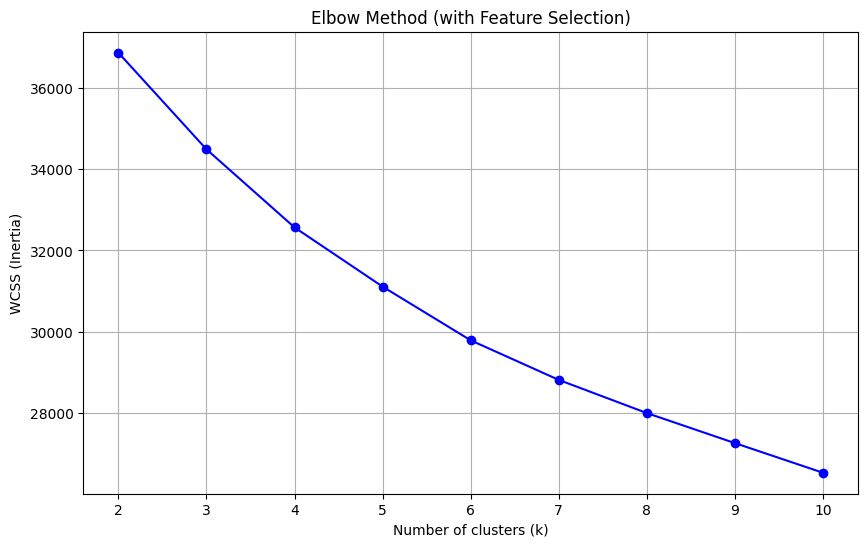

In [4]:
if __name__ == "__main__":
    warnings.filterwarnings('ignore')
    train_and_save_model()